In [ ]:
!pip freeze > requirements2.txt

# **TFM-DeepLearning-Style-Photo**
A gran parte de las personas, nos encanta el arte, pero, sin embargo, no todo el mundo tiene el talento para crearlo. A los artistas les define un estilo: onírico, costumbrista, minimalista, cinematográfico, cubismo...etc., estilo que los diferencia unos de otros. Las redes neuronales, permiten capturar un estilo y ser capaz de transferirlo a una imagen. Podríamos decir, que gracias a la CNN, no necesitamos pintar, para crear una imagen artística.

El objetivo de ésta parte del TFM, es mostrar una CNN que asigna automáticamente el etilo de una imagen a otra. 

En casos de uso que implique Vision por Ordenador, lo común es partir de modelos preentrenados, dado que hasta cierto punto, el reconocimiento o clasificación de imágenes es generico, y es donde podemos aprovechar éstos modelos. A lo generico, lo añadimos la particularidad de nuestro caso de uso.

Podemos empezar por ejemplo con AlexNet o GoogLeNet ó VGG (Oxford Visual Geometry Group), lo que haremos es proporcionarle datos nuevos que contengan  las clases de nuestro caso de uso.  

Procesaremos previamnete la imagen, utilizaremos el modelo preentrenado, en este caso AlexNet https://en.wikipedia.org/wiki/AlexNet. Lo más importante de este modelo, además de su capacidad de clasificar objetos en fotografías o imágenes, es que los pesos del modelo están disponibles libremente y se pueden reutilizar en nuestros  modelos específicos.

**Nota**: El estado del arte es muy amplio con respecto a éste punto, existen infinidad de proyectos con la API de Keras. Con fines de aprendizaje utilizaremos Pytorch, que es otro framework muy utilizado en Computer Vision.


![Figura01: Diagrama DL Style Photo](https://drive.google.com/uc?id=1y9WQc1b9fooERdcRc9AWUDba6Ztu2TmZ)


## **Montamos Google Drive para utilizarlo como almacenamiento**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## **Importamos las librerías necesarias**

In [2]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch.optim as optim
from torchvision import models
from torchvision import transforms as tf
import torch.nn.functional as F

# **Cargamos la CNN Alexnet**
* Tomaremos una parte de las features de alexnet

In [3]:
alexnet = models.alexnet(pretrained=True).features

for param in alexnet.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


# **GPU o CPU**
Intentemos trabajar con GPU

In [4]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    
alexnet.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# **Cargamos las imágenes**

In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [6]:
def transformation(img):
    
    tasks = tf.Compose([tf.Resize(256), 
                        tf.ToTensor(),
                        tf.Normalize(mean, std)])
    
    img = tasks(img)  
    img = img.unsqueeze(0)    
    
    return img

In [7]:
content_img = Image.open("/content/drive/My Drive/05.TFM-DeepLearning-Photo/02_DeepLearning-Photo-Style/data/photo/foto_103.jpg").convert('RGB')
style_img   = Image.open("/content/drive/My Drive/05.TFM-DeepLearning-Photo/02_DeepLearning-Photo-Style/data/style/style_jocker_02.jpg").convert('RGB')

Tamaño de la imagen de contenido es: (1000, 667)


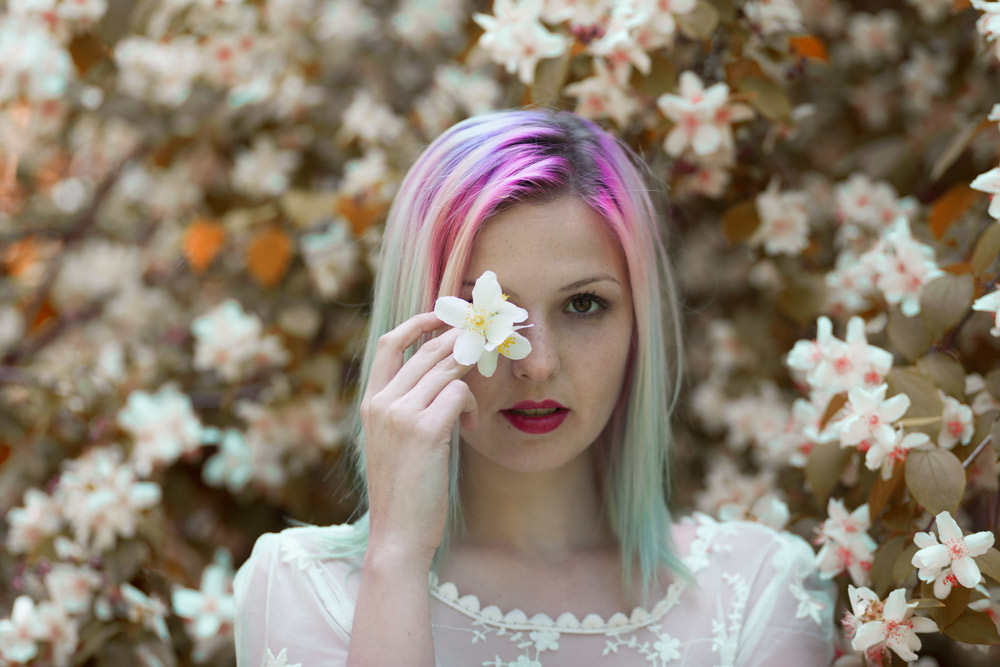

In [8]:
print('Tamaño de la imagen de contenido es:',content_img.size)
content_img

Tamaño de la imagen de estilo es: (640, 784)


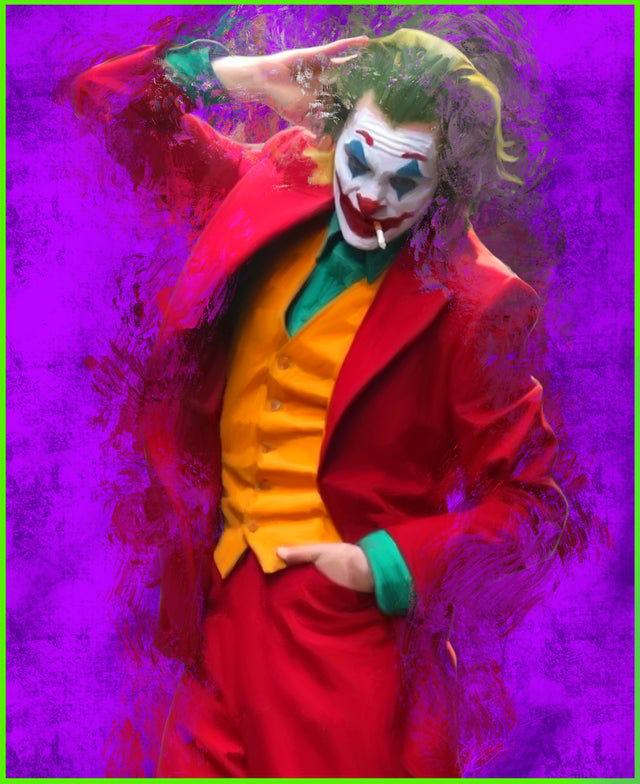

In [ ]:
print('Tamaño de la imagen de estilo es:',style_img.size)
style_img

In [ ]:
content_img = transformation(content_img).to(device)
style_img   = transformation(style_img).to(device)

In [ ]:
content_img.shape

torch.Size([1, 3, 256, 383])

In [ ]:
content_img

tensor([[[[ 0.3994,  0.4337,  0.6906,  ..., -0.0116,  0.0912,  0.7591],
          [ 0.3652,  0.3823,  0.6563,  ...,  1.2899,  1.3242,  1.3413],
          [ 0.2967,  0.2967,  0.5878,  ...,  1.6667,  1.6495,  1.6324],
          ...,
          [ 0.7419,  0.7419,  0.7419,  ..., -1.0219, -1.0219, -1.0390],
          [ 0.6392,  0.6906,  0.6049,  ..., -1.1075, -1.1247, -1.1247],
          [ 0.4851,  0.5364,  0.4679,  ..., -1.1589, -1.1932, -1.1932]],

         [[ 0.3102,  0.3452,  0.6078,  ..., -0.2850, -0.1099,  0.8004],
          [ 0.2577,  0.2927,  0.5903,  ...,  1.8158,  1.8333,  1.9034],
          [ 0.1702,  0.1877,  0.5028,  ...,  2.2185,  2.1835,  2.1134],
          ...,
          [ 0.7479,  0.6429,  0.5728,  ..., -1.1604, -1.1779, -1.1954],
          [ 0.8004,  0.6954,  0.4328,  ..., -1.2129, -1.2304, -1.2304],
          [ 0.5728,  0.5378,  0.3452,  ..., -1.2654, -1.2654, -1.2479]],

         [[-0.0267,  0.0953,  0.5136,  ..., -0.7761, -0.5321,  0.6356],
          [ 0.0082,  0.1128,  

In [ ]:
style_img.shape

torch.Size([1, 3, 313, 256])

In [ ]:
style_img

tensor([[[[-0.5424, -0.6281, -0.5938,  ..., -0.6965, -0.5596, -0.5938],
          [-0.6109, -0.6452, -0.3883,  ..., -0.2684, -0.4568, -0.5596],
          [-0.5767, -0.5424, -0.2513,  ...,  0.2796, -0.3027, -0.6452],
          ...,
          [-0.5767, -0.5767, -0.5082,  ..., -0.3883, -0.4911, -0.5424],
          [-0.5938, -0.6794, -0.5424,  ..., -0.5082, -0.6109, -0.5596],
          [-0.6109, -0.6623, -0.6109,  ..., -0.5596, -0.5938, -0.5938]],

         [[ 2.1134,  2.1660,  2.1835,  ...,  2.2535,  2.1660,  2.1660],
          [ 2.1310,  2.1835,  1.4132,  ...,  1.3606,  2.0259,  2.1310],
          [ 2.1485,  2.0609, -0.2325,  ..., -0.5826,  1.7458,  2.1835],
          ...,
          [ 2.1134,  2.0609,  0.4503,  ..., -0.1625,  1.2906,  1.4832],
          [ 2.1310,  2.2185,  2.0609,  ...,  1.3782,  1.5357,  1.4832],
          [ 2.1660,  2.1660,  2.1310,  ...,  1.5007,  1.5007,  1.5357]],

         [[-1.7347, -1.7173, -1.6302,  ..., -1.6824, -1.7173, -1.6650],
          [-1.5953, -1.6824, -

# **Convertir una imagen expresada en tensores en formato imagen**
* Clonar el tensor
* Convierte el tensor en una matriz numérica y apriétalo para que sea 3d
* Pasamos la imagen de CHW -> HWC [Height x Width x Channels].
* Normalizar la imagen

In [ ]:
def tensor_to_image(tensor):
    # Partimos de un tensor
    image = tensor.clone().detach()
    # Convertimos el tensor en un np array y usamos squezee para eliminar la unidimensionalidad  
    image = image.cpu().numpy().squeeze()
    
    # CHW -> HWC
    image = image.transpose(1, 2, 0)
    
    # Normalizamos la imagen  
    image *= np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    
    return image

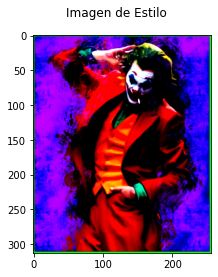

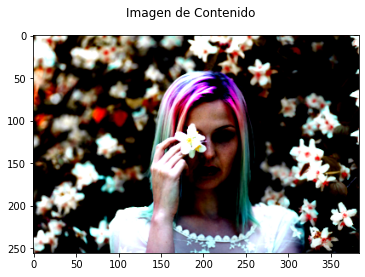

In [ ]:
# Para la imagen del que copiaremos el estilo
img = tensor_to_image(style_img)
fig = plt.figure()
fig.suptitle('Imagen de Estilo')
plt.imshow(img)

# PAra la imagen a la que le aplicaremos el estilo
img = tensor_to_image(content_img)
fig = plt.figure()
fig.suptitle('Imagen de Contenido')
plt.imshow(img)

# **Extraemos la features de las imagenes**
Usamos las capas 0,3 y 6 para la información de estilo y la capa 8 para la información de contenido.

In [ ]:
LAYERS_OF_INTEREST = {'0': 'conv1_1', 
                      '3': 'conv2_1',  
                      '6': 'conv3_1',
                      '8': 'conv3_2',
                      '10': 'conv3_3'}

In [ ]:
def apply_model_and_extract_features(image, model):
    x = image

    features = {}
    
    for name, layer in model._modules.items():
        x = layer(x)
        
        if name in LAYERS_OF_INTEREST:
            features[LAYERS_OF_INTEREST[name]] = x   
            
    return features

In [ ]:
content_img_features = apply_model_and_extract_features(content_img, alexnet)
style_img_features   = apply_model_and_extract_features(style_img, alexnet)

# **Features y matriz de Gram**
Para obtener el contenido y las representaciones de estilo de una imagen, tenemos que pasar una imagen hacia adelante a través de la red hasta llegar a la (s) capa (s) deseada (s) y luego obtener la salida de esa capa. 
Necesitamos algo llamado Gram Matrix para obtener las representaciones de estilo en el formato requerido para entrenar nuestro modelo. 

In [ ]:
def calculate_gram_matrix(tensor):
    
    _, channels, height, width = tensor.size()    
    tensor = tensor.view(channels, height * width)
    gram_matrix = torch.mm(tensor, tensor.t())
    gram_matrix = gram_matrix.div(channels * height * width) 
    
    return gram_matrix

In [ ]:
style_features_gram_matrix = {layer: calculate_gram_matrix(style_img_features[layer]) for layer in 
                                                    style_img_features}

style_features_gram_matrix

{'conv1_1': tensor([[0.0766, 0.0164, 0.0234,  ..., 0.0030, 0.0201, 0.0026],
         [0.0164, 0.0360, 0.0219,  ..., 0.0013, 0.0079, 0.0014],
         [0.0234, 0.0219, 0.1273,  ..., 0.0031, 0.0247, 0.0032],
         ...,
         [0.0030, 0.0013, 0.0031,  ..., 0.0049, 0.0034, 0.0008],
         [0.0201, 0.0079, 0.0247,  ..., 0.0034, 0.0325, 0.0018],
         [0.0026, 0.0014, 0.0032,  ..., 0.0008, 0.0018, 0.0028]]),
 'conv2_1': tensor([[0.0072, 0.0020, 0.0019,  ..., 0.0026, 0.0051, 0.0018],
         [0.0020, 0.0342, 0.0019,  ..., 0.0071, 0.0090, 0.0043],
         [0.0019, 0.0019, 0.0475,  ..., 0.0040, 0.0008, 0.0035],
         ...,
         [0.0026, 0.0071, 0.0040,  ..., 0.0636, 0.0005, 0.0099],
         [0.0051, 0.0090, 0.0008,  ..., 0.0005, 0.0471, 0.0004],
         [0.0018, 0.0043, 0.0035,  ..., 0.0099, 0.0004, 0.0152]]),
 'conv3_1': tensor([[1.7476e-02, 2.5249e-04, 1.0340e-02,  ..., 7.1219e-05, 2.2826e-04,
          1.9823e-03],
         [2.5249e-04, 1.6043e-02, 2.4073e-02,  ..., 0.00

# **Entrenamiento del Modelo**
Con las features, realizaremos un conjunto de iteraciones hasta llegar a la imagen objetivo.
Dentro del ciclo de iteración, calcularemos las pérdidas de contenido y estilo y actualizaremos nuestra imagen objetivo.

* Iniciar el proceso de minimización de pérdidas
* Ejecuta un bucle con un número de iteraciones.
* Calcule la pérdida de contenido (de la imagen de contenido y del objetivo) usando MSE
* Calcular la pérdida de estilo (a partir de la imagen de estilo y el objetivo) usando MSE
* La pérdida combinada es entonces retropropagada y minimizada.
* Usando la pérdida minimizada, se actualizan los parámetros de la red, lo que actualiza aún más la imagen del objetivo


In [ ]:
weights = {'conv1_1': 1.0, 'conv2_1': 0.8, 'conv3_1': 0.25}

In [ ]:
target = content_img.clone().requires_grad_(True).to(device)

optimizer = optim.RMSprop([target], lr=0.003)

In [ ]:
for i in range(1, 2000):
    
    target_features = apply_model_and_extract_features(target, alexnet)    
    content_loss = F.mse_loss (target_features['conv3_1'], content_img_features['conv3_1'])
    
    style_loss = 0
    for layer in weights:
        
        target_feature = target_features[layer]
        target_gram_matrix = calculate_gram_matrix(target_feature)
        style_gram_matrix = style_features_gram_matrix[layer]        
        layer_loss = F.mse_loss (target_gram_matrix, style_gram_matrix)
        layer_loss *= weights[layer]        
        _, channels, height, width = target_feature.shape
        style_loss += layer_loss      
    total_loss = 1000000 * style_loss + content_loss
    
    if i % 50 == 0:
        print ('Epoch {}:, Style Loss : {:4f}, Content Loss : {:4f}'.format( i, style_loss, content_loss))

    optimizer.zero_grad()    
    total_loss.backward()    
    optimizer.step()

plt.plot(loss_values)

Epoch 50:, Style Loss : 0.009818, Content Loss : 4.174915
Epoch 100:, Style Loss : 0.005999, Content Loss : 5.561190
Epoch 150:, Style Loss : 0.003409, Content Loss : 5.889335
Epoch 200:, Style Loss : 0.001843, Content Loss : 5.916190
Epoch 250:, Style Loss : 0.001037, Content Loss : 5.909796
Epoch 300:, Style Loss : 0.000663, Content Loss : 5.930164
Epoch 350:, Style Loss : 0.000473, Content Loss : 5.994356
Epoch 400:, Style Loss : 0.000355, Content Loss : 6.075259


# **Resultados del modelo.**
Los siguientes son los resultados dedel entrenamiento del modelo.

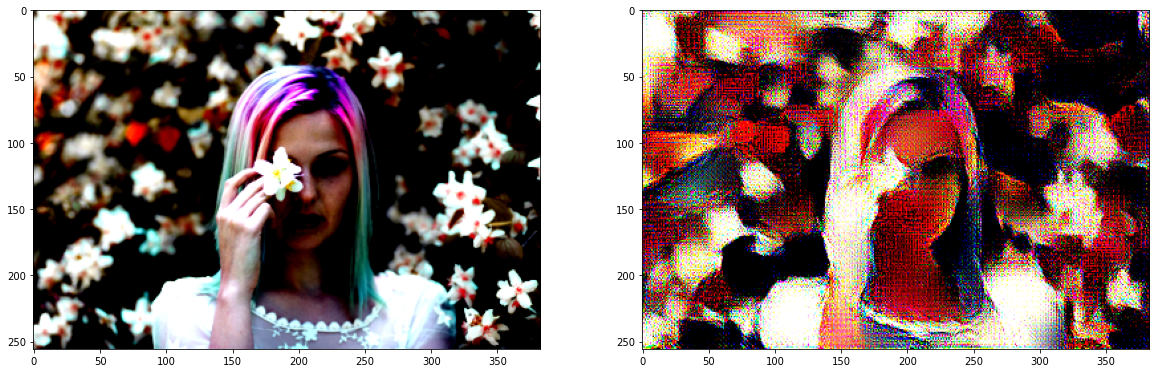

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor_to_image(content_img))
ax2.imshow(tensor_to_image(target))

In [ ]:
!pip freeze > requirements2.txt